## FaceRecognition 21/05/2020

It is to identify the front-facing faces without any facial accessories.

In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

%matplotlib inline

In [52]:
cascade_path = './model/cv2/haarcascade_frontalface_alt2.xml' # contains the path to the cv2 model file

In [53]:
image_dir_basepath = './images/' # path to the training dataset directory
names = ['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt','Irrfan_Khan','Jen_Aniston','Jen_Lawrence','Johnny_Depp','Pankaj_Tripathi','Robert_DowneyJr','Will_Smith']
image_size = 160

In [54]:
model_path = './model/keras/model/facenet_keras.h5'  # path to the predefined keras model for facenet
model = load_model(model_path)

In [66]:
# the function prewhiten and l2_normalize subtract the average and 
# normalize the range of the pixel values of input images respectively.


def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [67]:
# the function deals with cropping of image along the detected face

def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [68]:
# the function is used to find the respective encoding of the images

def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [69]:
# training of the data set

def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [70]:
# predicting the class of the input images

def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [89]:
le, clf = train(image_dir_basepath, names)

In [100]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [101]:
pred = infer(le, clf, test_filepaths)

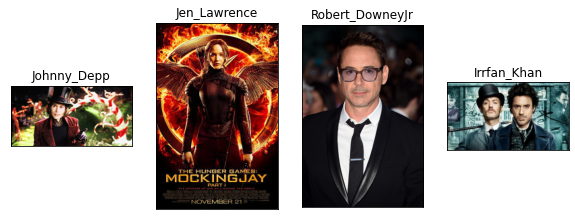

In [102]:
# predicts the name of few of the test images

fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    axes[i].set_title(str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

The model only detects people from images containing one face. Presence of more than 1 people result in wrong predcitions. The model requires a large no. of training set examples.